# Introduction

### Smaller net: [32,32]

In [30]:
import os
import gymnasium as gym
import torch
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.utils_custom_policies import HarmonicPolicy  # Import your custom policy if needed


# --- Load Trained Models ---
seed = 1
env_name = 'CartPole-v1'
agent_type = 'ppo-harmonic'


# Create environment (assuming same settings as training)
env = gym.make(env_name)
env.reset(seed=seed)
env = DummyVecEnv([lambda: env])

# Load models
model_path = f'models/{env_name}/{agent_type}_{seed}.zip'
if os.path.exists(model_path):
    model = PPO.load(model_path, env=env)

# Number of episodes and maximum steps per episode
num_episodes = 1
max_steps = 500

state_embeddings = []

for episode in range(num_episodes):
    obs = env.reset()  # Gymnasium reset returns (obs, info)
    ep_return = 0
    for step in range(max_steps):
        # Convert the observation to a tensor (unsqueeze to add batch dim)
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        
        # Extract the state embedding via the model's mlp_extractor.
        # The mlp_extractor returns (features_pi, features_vf)
        features_pi, _ = model.policy.mlp_extractor(obs_tensor)
        
        # Append the extracted embedding (remove the batch dimension)
        state_embeddings.append(features_pi.detach().squeeze(0).cpu().numpy())
        
        # Get action from the model and step the environment
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        ep_return += reward
        if done:
            break

    print(f'Return = {ep_return}')

state_embeddings = np.array(state_embeddings)
state_embeddings = state_embeddings.reshape(-1, state_embeddings.shape[2]) 
print("State Embeddings shape:", state_embeddings.shape)

# Action embeddings (for Harmonic approach)
harmonic_policy = model.policy  # This is the HarmonicPolicy instance
action_embeddings = harmonic_policy.weights.detach().cpu().numpy()
print("Action Embeddings Shape:", action_embeddings.shape)


Return = [500.]
State Embeddings shape: (500, 16)
Action Embeddings Shape: (2, 16)


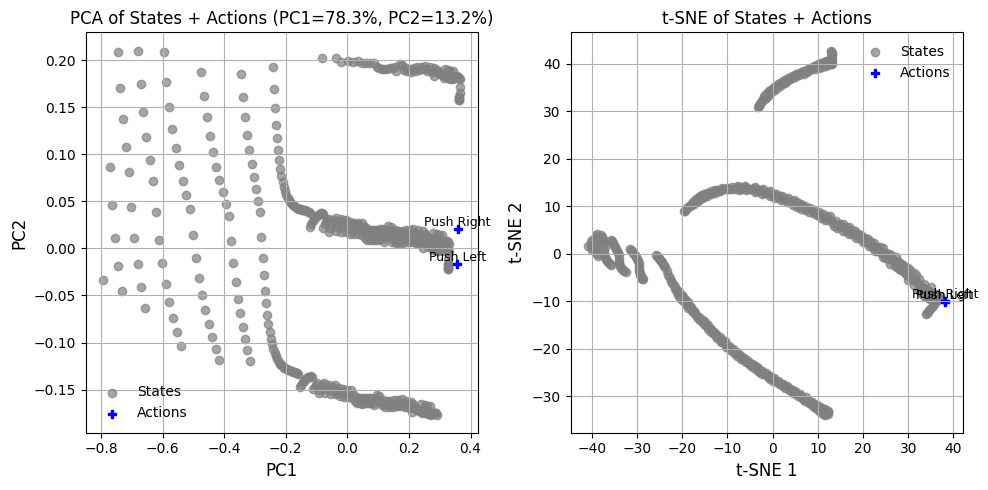

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# For CartPole, we now have 2 actions: 0: "Push Left", 1: "Push Right"
action_labels = ["Push Left", "Push Right"]

# Combine states and actions
combined = np.vstack([state_embeddings, action_embeddings])

# Run PCA on the combined embeddings
pca = PCA(n_components=2)
combined_pca = pca.fit_transform(combined)

# Split the PCA result back into states vs. actions
num_states = state_embeddings.shape[0]
pca_states = combined_pca[:num_states]
pca_actions = combined_pca[num_states:]

# Run t-SNE on the combined embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=20)
combined_tsne = tsne.fit_transform(combined)

# Split the t-SNE result back into states vs. actions
tsne_states = combined_tsne[:num_states]
tsne_actions = combined_tsne[num_states:]

# --- Plot PCA ---
plt.figure(figsize=(10, 5))

# Left subplot: PCA
plt.subplot(1, 2, 1)

# Plot states (grey dots)
plt.scatter(pca_states[:, 0], pca_states[:, 1], color='grey', alpha=0.7, label='States')

# Plot actions (blue 'P' markers)
plt.scatter(pca_actions[:, 0], pca_actions[:, 1], c='blue', marker='P', label='Actions')

# Annotate states (if you have coordinates available)
# for i, (r, c) in enumerate(coords):
#     x, y = pca_states[i]
#     plt.annotate(f"({r},{c})", (x, y), fontsize=7, alpha=0.7)

# Annotate action points with the updated labels
for i, label in enumerate(action_labels):
    x, y = pca_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

var_ratio = pca.explained_variance_ratio_
pc1, pc2 = var_ratio[0] * 100, var_ratio[1] * 100
plt.title(f"PCA of States + Actions (PC1={pc1:.1f}%, PC2={pc2:.1f}%)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()

# --- Plot t-SNE ---
plt.subplot(1, 2, 2)

# Plot states (grey dots)
plt.scatter(tsne_states[:, 0], tsne_states[:, 1], color='grey', alpha=0.7, label='States')

# Plot actions (blue 'P' markers)
plt.scatter(tsne_actions[:, 0], tsne_actions[:, 1], c='blue', marker='P', label='Actions')

# Annotate states
# for i, (r, c) in enumerate(coords):
#     x, y = tsne_states[i]
#     plt.annotate(f"({r},{c})", (x, y), fontsize=7, alpha=0.7)

# Annotate action points with the updated labels
for i, label in enumerate(action_labels):
    x, y = tsne_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

plt.title("t-SNE of States + Actions")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### Bigger net: [128, 128, 128]

In [56]:
import os
import gymnasium as gym
import torch
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.utils_custom_policies import HarmonicPolicy  # Import your custom policy if needed


# --- Load Trained Models ---
seed = 3
seed = 11
env_name = 'CartPole-v1'
agent_type = 'ppo-harmonic'


# Create environment (assuming same settings as training)
env = gym.make(env_name)
env.reset(seed=seed)
env = DummyVecEnv([lambda: env])

# Load models
model_path = f'models/{env_name}-big/{agent_type}_{seed}.zip'
if os.path.exists(model_path):
    model = PPO.load(model_path, env=env)

# Number of episodes and maximum steps per episode
num_episodes = 1
max_steps = 500

state_embeddings = []

for episode in range(num_episodes):
    obs = env.reset()  # Gymnasium reset returns (obs, info)
    ep_return = 0
    for step in range(max_steps):
        # Convert the observation to a tensor (unsqueeze to add batch dim)
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        
        # Extract the state embedding via the model's mlp_extractor.
        # The mlp_extractor returns (features_pi, features_vf)
        features_pi, _ = model.policy.mlp_extractor(obs_tensor)
        
        # Append the extracted embedding (remove the batch dimension)
        state_embeddings.append(features_pi.detach().squeeze(0).cpu().numpy())
        
        # Get action from the model and step the environment
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        ep_return += reward
        if done:
            break

    print(f'Return = {ep_return}')

state_embeddings = np.array(state_embeddings)
state_embeddings = state_embeddings.reshape(-1, state_embeddings.shape[2]) 
print("State Embeddings shape:", state_embeddings.shape)

# Action embeddings (for Harmonic approach)
harmonic_policy = model.policy  # This is the HarmonicPolicy instance
action_embeddings = harmonic_policy.weights.detach().cpu().numpy()
print("Action Embeddings Shape:", action_embeddings.shape)


Return = [500.]
State Embeddings shape: (500, 128)
Action Embeddings Shape: (2, 128)


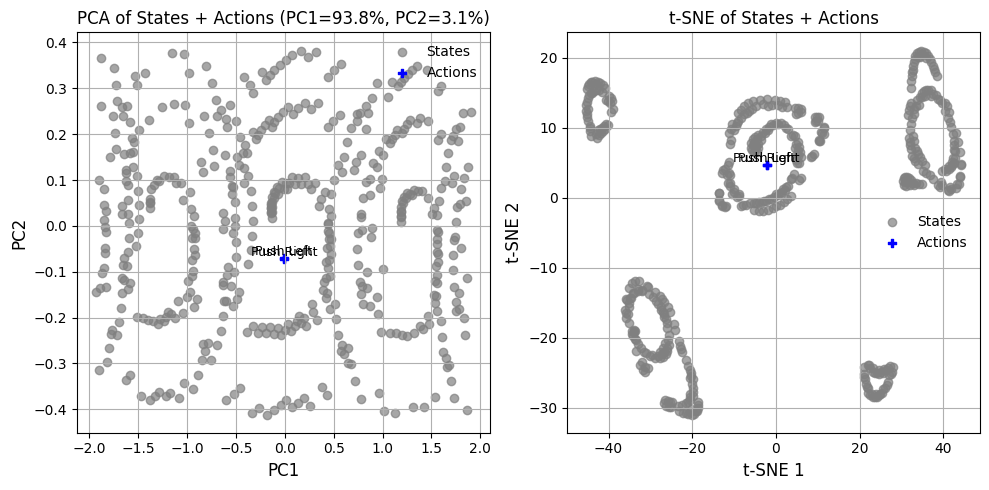

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# For CartPole, we now have 2 actions: 0: "Push Left", 1: "Push Right"
action_labels = ["Push Left", "Push Right"]

# Combine states and actions
combined = np.vstack([state_embeddings, action_embeddings])

# Run PCA on the combined embeddings
pca = PCA(n_components=2)
combined_pca = pca.fit_transform(combined)

# Split the PCA result back into states vs. actions
num_states = state_embeddings.shape[0]
pca_states = combined_pca[:num_states]
pca_actions = combined_pca[num_states:]

# Run t-SNE on the combined embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=20)
combined_tsne = tsne.fit_transform(combined)

# Split the t-SNE result back into states vs. actions
tsne_states = combined_tsne[:num_states]
tsne_actions = combined_tsne[num_states:]

# --- Plot PCA ---
plt.figure(figsize=(10, 5))

# Left subplot: PCA
plt.subplot(1, 2, 1)

# Plot states (grey dots)
plt.scatter(pca_states[:, 0], pca_states[:, 1], color='grey', alpha=0.7, label='States')

# Plot actions (blue 'P' markers)
plt.scatter(pca_actions[:, 0], pca_actions[:, 1], c='blue', marker='P', label='Actions')

# Annotate states (if you have coordinates available)
# for i, (r, c) in enumerate(coords):
#     x, y = pca_states[i]
#     plt.annotate(f"({r},{c})", (x, y), fontsize=7, alpha=0.7)

# Annotate action points with the updated labels
for i, label in enumerate(action_labels):
    x, y = pca_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

var_ratio = pca.explained_variance_ratio_
pc1, pc2 = var_ratio[0] * 100, var_ratio[1] * 100
plt.title(f"PCA of States + Actions (PC1={pc1:.1f}%, PC2={pc2:.1f}%)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()

# --- Plot t-SNE ---
plt.subplot(1, 2, 2)

# Plot states (grey dots)
plt.scatter(tsne_states[:, 0], tsne_states[:, 1], color='grey', alpha=0.7, label='States')

# Plot actions (blue 'P' markers)
plt.scatter(tsne_actions[:, 0], tsne_actions[:, 1], c='blue', marker='P', label='Actions')

# Annotate states
# for i, (r, c) in enumerate(coords):
#     x, y = tsne_states[i]
#     plt.annotate(f"({r},{c})", (x, y), fontsize=7, alpha=0.7)

# Annotate action points with the updated labels
for i, label in enumerate(action_labels):
    x, y = tsne_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

plt.title("t-SNE of States + Actions")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### Roughwork

Seed 0 - State Embeddings shape: (175, 128)
Seed 0 - Action Embeddings shape: (2, 128)
Seed 1 - State Embeddings shape: (285, 128)
Seed 1 - Action Embeddings shape: (2, 128)
Seed 2 - State Embeddings shape: (34, 128)
Seed 2 - Action Embeddings shape: (2, 128)
Seed 3 - State Embeddings shape: (500, 128)
Seed 3 - Action Embeddings shape: (2, 128)
Seed 4 - State Embeddings shape: (146, 128)
Seed 4 - Action Embeddings shape: (2, 128)
Seed 5 - State Embeddings shape: (139, 128)
Seed 5 - Action Embeddings shape: (2, 128)
Seed 6 - State Embeddings shape: (59, 128)
Seed 6 - Action Embeddings shape: (2, 128)
Seed 7 - State Embeddings shape: (145, 128)
Seed 7 - Action Embeddings shape: (2, 128)
Seed 8 - State Embeddings shape: (173, 128)
Seed 8 - Action Embeddings shape: (2, 128)
Seed 9 - State Embeddings shape: (34, 128)
Seed 9 - Action Embeddings shape: (2, 128)
Seed 10 - State Embeddings shape: (55, 128)
Seed 10 - Action Embeddings shape: (2, 128)
Seed 11 - State Embeddings shape: (500, 128)


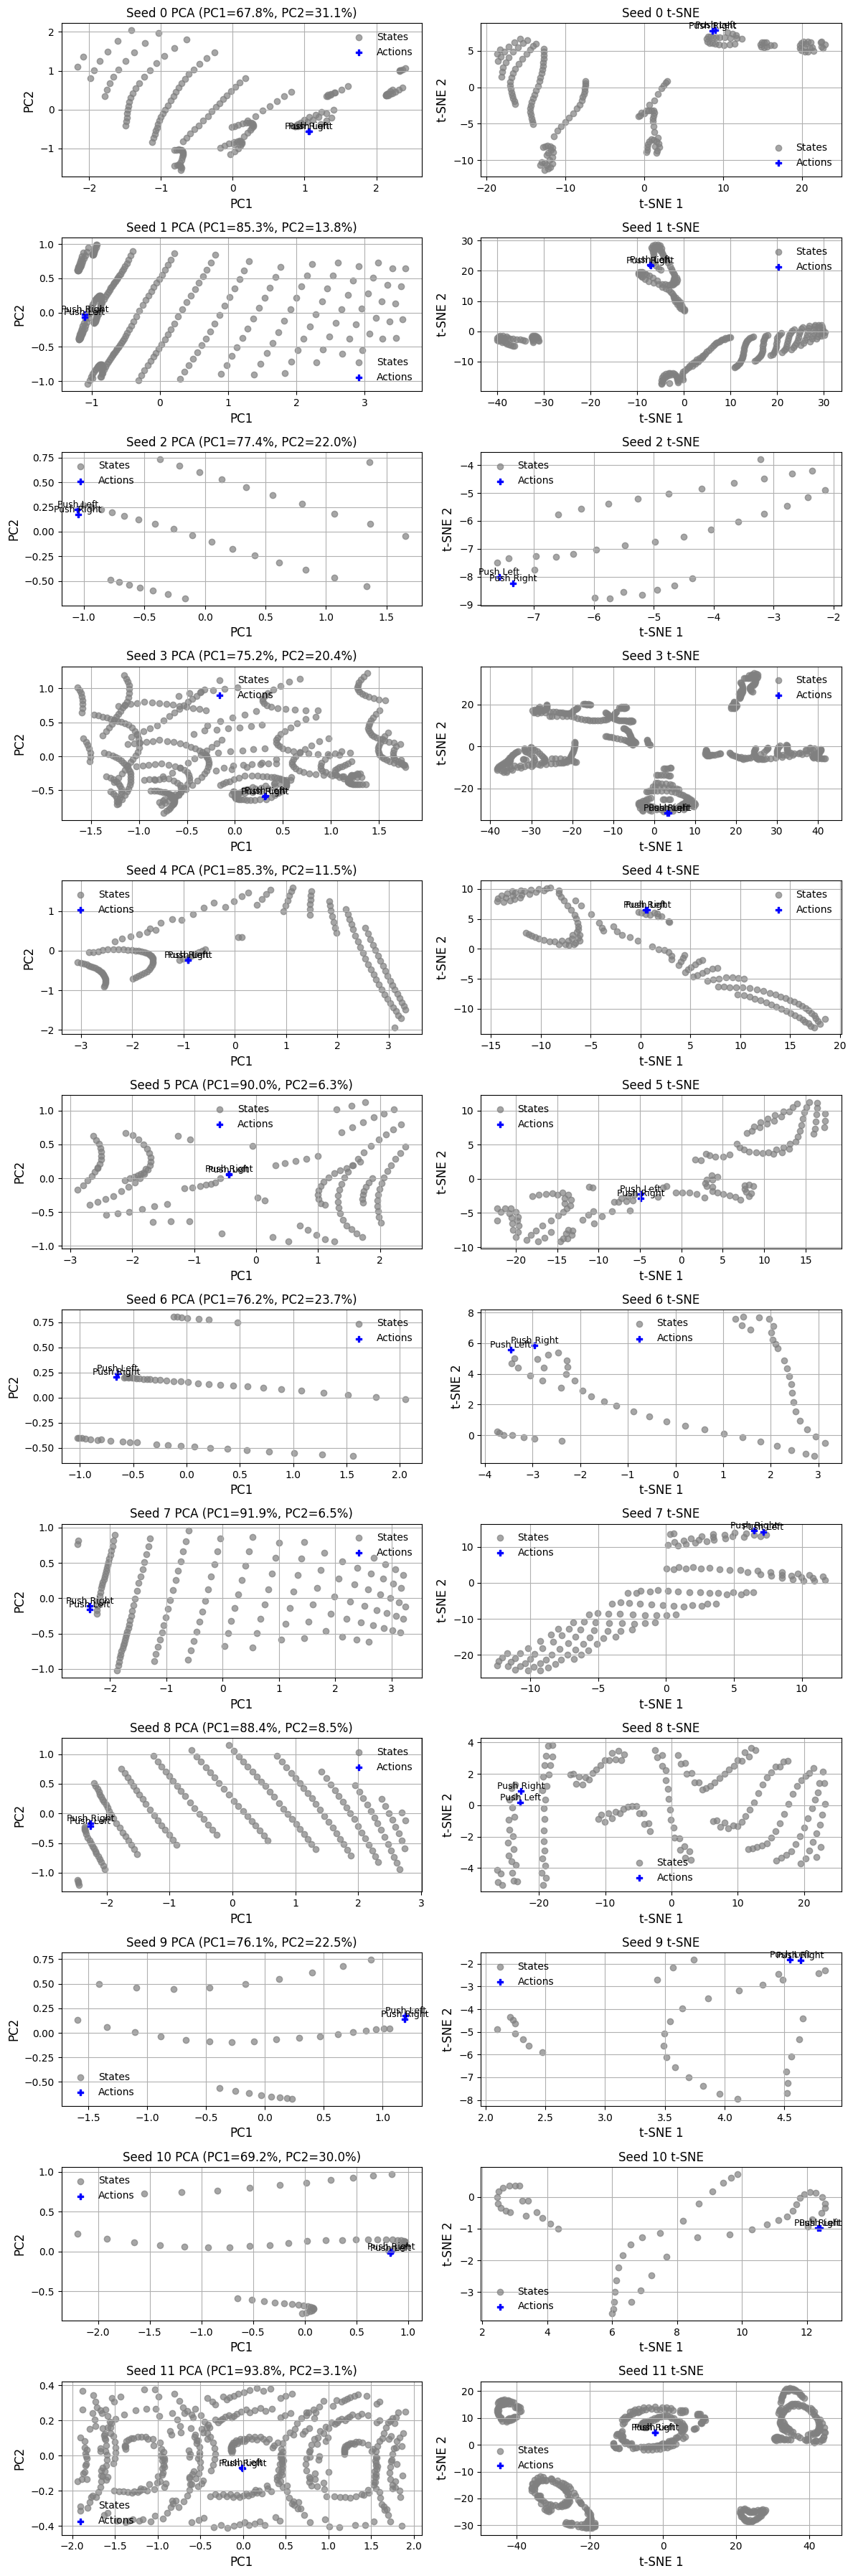

In [62]:
import os
import gymnasium as gym
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.utils_custom_policies import HarmonicPolicy  # Your custom policy

# Parameters
ensemble_seeds = list(range(12))  # Seeds 0 to 11
env_name = 'CartPole-v1'
agent_type = 'ppo-harmonic'
num_episodes = 1
max_steps = 500

# Prepare subplots: 12 rows x 2 columns
fig, axes = plt.subplots(len(ensemble_seeds), 2, figsize=(12, len(ensemble_seeds)*3))

# For CartPole, we have 2 actions.
action_labels = ["Push Left", "Push Right"]

for i, seed in enumerate(ensemble_seeds):
    # Create and seed environment
    env = gym.make(env_name)
    env.reset()
    env = DummyVecEnv([lambda: env])

    # Build model path; adjust path if needed.
    model_path = f'models/{env_name}-big/{agent_type}_{seed}.zip'
    if os.path.exists(model_path):
        model = PPO.load(model_path, env=env)
    else:
        print(f"Model for seed {seed} not found. Skipping.")
        continue

    state_embeddings_list = []
    
    # Run one episode and collect state embeddings
    obs = env.reset()  # Gymnasium reset returns (obs, info)
    for step in range(max_steps):
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        # Extract embedding from the policy's MLP extractor.
        features_pi, _ = model.policy.mlp_extractor(obs_tensor)
        embedding = features_pi.detach().squeeze(0).cpu().numpy()
        state_embeddings_list.append(embedding)
        
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        if done:
            break

    # Convert list to NumPy array and automatically flatten extra dims.
    state_embeddings = np.array(state_embeddings_list)
    num_samples = state_embeddings.shape[0]
    state_embeddings = state_embeddings.reshape(num_samples, -1)
    print(f"Seed {seed} - State Embeddings shape: {state_embeddings.shape}")

    # Action embeddings from the harmonic policy (assumed to be stored in 'weights')
    harmonic_policy = model.policy
    action_embeddings = harmonic_policy.weights.detach().cpu().numpy()
    print(f"Seed {seed} - Action Embeddings shape: {action_embeddings.shape}")

    # Combine states and actions for visualization
    combined = np.vstack([state_embeddings, action_embeddings])
    
    # PCA
    pca = PCA(n_components=2)
    combined_pca = pca.fit_transform(combined)
    num_states = state_embeddings.shape[0]
    pca_states = combined_pca[:num_states]
    pca_actions = combined_pca[num_states:]
    
    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=20)
    combined_tsne = tsne.fit_transform(combined)
    tsne_states = combined_tsne[:num_states]
    tsne_actions = combined_tsne[num_states:]
    
    # Plot PCA in left subplot of row i
    ax_pca = axes[i, 0]
    ax_pca.scatter(pca_states[:, 0], pca_states[:, 1], color='grey', alpha=0.7, label='States')
    ax_pca.scatter(pca_actions[:, 0], pca_actions[:, 1], c='blue', marker='P', label='Actions')
    for j, label in enumerate(action_labels):
        x, y = pca_actions[j]
        ax_pca.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')
    var_ratio = pca.explained_variance_ratio_
    pc1, pc2 = var_ratio[0] * 100, var_ratio[1] * 100
    ax_pca.set_title(f"Seed {seed} PCA (PC1={pc1:.1f}%, PC2={pc2:.1f}%)")
    ax_pca.set_xlabel("PC1")
    ax_pca.set_ylabel("PC2")
    ax_pca.grid(True)
    ax_pca.legend()

    # Plot t-SNE in right subplot of row i
    ax_tsne = axes[i, 1]
    ax_tsne.scatter(tsne_states[:, 0], tsne_states[:, 1], color='grey', alpha=0.7, label='States')
    ax_tsne.scatter(tsne_actions[:, 0], tsne_actions[:, 1], c='blue', marker='P', label='Actions')
    for j, label in enumerate(action_labels):
        x, y = tsne_actions[j]
        ax_tsne.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')
    ax_tsne.set_title(f"Seed {seed} t-SNE")
    ax_tsne.set_xlabel("t-SNE 1")
    ax_tsne.set_ylabel("t-SNE 2")
    ax_tsne.grid(True)
    ax_tsne.legend()

plt.tight_layout()
plt.show()

### Stuff here

In [101]:
import os
import gymnasium as gym
import torch
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.utils_custom_policies import HarmonicPolicy  # Import your custom policy if needed


# --- Load Trained Models ---
seed = 2
env_name = 'LunarLander-v2'
agent_type = 'ppo-harmonic'


# Create environment (assuming same settings as training)
env = gym.make(env_name)
env.reset(seed=seed)
env = DummyVecEnv([lambda: env])

# Load models
model_path = f'models/{env_name}/{agent_type}_{seed}.zip'
if os.path.exists(model_path):
    model = PPO.load(model_path, env=env)

# Number of episodes and maximum steps per episode
num_episodes = 10
state_embeddings = []
for episode in range(num_episodes):
    obs = env.reset()  # Gymnasium reset returns (obs, info)
    ep_return = 0
    done = False
    while not done:
        # Convert the observation to a tensor (unsqueeze to add batch dim)
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        
        # Extract the state embedding via the model's mlp_extractor.
        # The mlp_extractor returns (features_pi, features_vf)
        features_pi, _ = model.policy.mlp_extractor(obs_tensor)
        
        # Append the extracted embedding (remove the batch dimension)
        state_embeddings.append(features_pi.detach().squeeze(0).cpu().numpy())
        
        # Get action from the model and step the environment
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        ep_return += reward

    print(f'Return = {ep_return}')

state_embeddings = np.array(state_embeddings)
state_embeddings = state_embeddings.reshape(-1, state_embeddings.shape[2]) 
print("State Embeddings shape:", state_embeddings.shape)

# Action embeddings (for Harmonic approach)
harmonic_policy = model.policy  # This is the HarmonicPolicy instance
action_embeddings = harmonic_policy.weights.detach().cpu().numpy()
print("Action Embeddings Shape:", action_embeddings.shape)

Return = [225.15045]
Return = [222.34622]
Return = [205.73643]
Return = [254.43842]
Return = [226.3681]
Return = [240.0548]
Return = [242.32382]
Return = [264.24973]
Return = [-33.993927]
Return = [276.16705]
State Embeddings shape: (3636, 128)
Action Embeddings Shape: (4, 128)


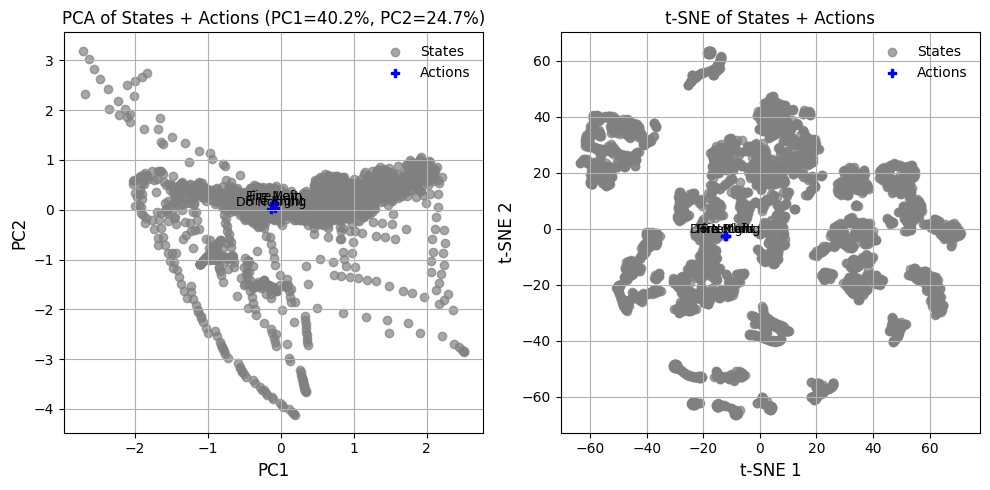

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# For LunarLander-v2, we have 4 actions:
action_labels = ["Do Nothing", "Fire Left", "Fire Main", "Fire Right"]

# Combine states and actions
combined = np.vstack([state_embeddings, action_embeddings])

# Run PCA on the combined embeddings
pca = PCA(n_components=2)
combined_pca = pca.fit_transform(combined)

# Split the PCA result back into states vs. actions
num_states = state_embeddings.shape[0]
pca_states = combined_pca[:num_states]
pca_actions = combined_pca[num_states:]

# Run t-SNE on the combined embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
combined_tsne = tsne.fit_transform(combined)

# Split the t-SNE result back into states vs. actions
tsne_states = combined_tsne[:num_states]
tsne_actions = combined_tsne[num_states:]

# --- Plot PCA ---
plt.figure(figsize=(10, 5))

# Left subplot: PCA
plt.subplot(1, 2, 1)

# Plot states (grey dots)
plt.scatter(pca_states[:, 0], pca_states[:, 1], color='grey', alpha=0.7, label='States')

# Plot actions (blue 'P' markers)
plt.scatter(pca_actions[:, 0], pca_actions[:, 1], c='blue', marker='P', label='Actions')

# Annotate action points with the updated labels
for i, label in enumerate(action_labels):
    x, y = pca_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

var_ratio = pca.explained_variance_ratio_
pc1, pc2 = var_ratio[0] * 100, var_ratio[1] * 100
plt.title(f"PCA of States + Actions (PC1={pc1:.1f}%, PC2={pc2:.1f}%)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()

# --- Plot t-SNE ---
plt.subplot(1, 2, 2)

# Plot states (grey dots)
plt.scatter(tsne_states[:, 0], tsne_states[:, 1], color='grey', alpha=0.7, label='States')

# Plot actions (blue 'P' markers)
plt.scatter(tsne_actions[:, 0], tsne_actions[:, 1], c='blue', marker='P', label='Actions')

# Annotate action points with the updated labels
for i, label in enumerate(action_labels):
    x, y = tsne_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

plt.title("t-SNE of States + Actions")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

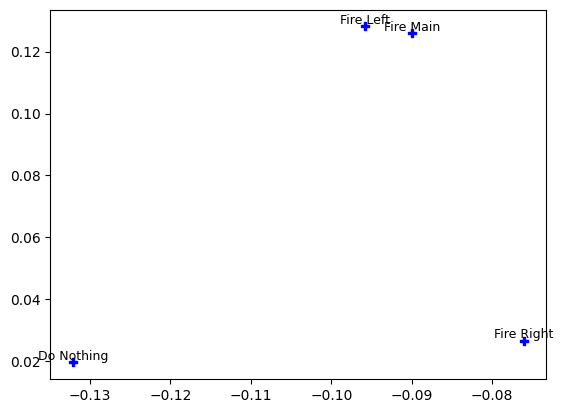

In [103]:
# Plot actions (blue 'P' markers)
plt.scatter(pca_actions[:, 0], pca_actions[:, 1], c='blue', marker='P', label='Actions')

# Annotate action points with the updated labels
for i, label in enumerate(action_labels):
    x, y = pca_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

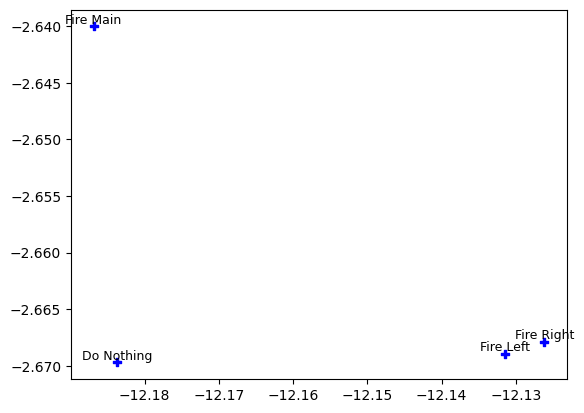

In [104]:
# Plot actions (blue 'P' markers)
plt.scatter(tsne_actions[:, 0], tsne_actions[:, 1], c='blue', marker='P', label='Actions')

# Annotate action points with the updated labels
for i, label in enumerate(action_labels):
    x, y = tsne_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')